In [11]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


X,Y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,stratify=Y,random_state=42)

# del X_train,X_test

In [12]:
Y_test.shape

(2500,)

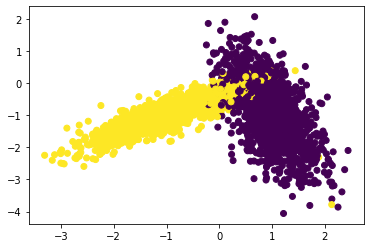

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=Y_test)
plt.show()

# Implementing Custom RandomSearchCV

<pre>
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>

In [14]:
from itertools import combinations 
from statistics import mean 

def train_to_group(dataset, group_size, folds):
    
    group_list = []
    x = 0
    y = group_size
    
    for i in range(0, folds):
        a = dataset[x:y]
        x = x + group_size
        y = y + group_size
        group_list.append(a)
    
    return group_list

def group_flat(dataset):
    
    flat_list = []
    for sublist in dataset:
        for item in sublist:
            flat_list.append(item)
    
    return flat_list  

def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    
    #print("x_train", x_train)
    #print("y_train", y_train)
    
    print("*"*50)
    
    trainscores = []
    cvscores  = []  
    group_size = int(len(x_train)/folds)
    
    for k in tqdm(params):
        
        print("at k value:", k)
        trainscores_folds = []
        cvscores_folds  = []
        
        x_train_groups_list = train_to_group(x_train, group_size, folds)
        y_train_groups_list = train_to_group(y_train, group_size, folds)
        
        x_comb_groups = combinations(x_train_groups_list, folds-1) 
        x_comb_groups = list(x_comb_groups)
        
        y_comb_groups = combinations(y_train_groups_list, folds-1)
        y_comb_groups = list(y_comb_groups)
        
        for j in range(0, folds):
            
            #print("for fold value:",j)
            
            x_train_group = x_comb_groups[j]
            x_test_set = x_train_groups_list[(folds - 1) - j]
            y_train_group = y_comb_groups[j]
            y_test_set = y_train_groups_list[(folds - 1) - j]
            
            x_train_set = group_flat(x_train_group)
            y_train_set = group_flat(y_train_group)
            
            classifier.n_neighbors = k
            classifier.fit(x_train_set,y_train_set)

            #for test data set
            Y_predicted = classifier.predict(x_test_set)
            cvscores_folds.append(accuracy_score(y_test_set, Y_predicted))
            
            Y_predicted = classifier.predict(x_train_set)
            trainscores_folds.append(accuracy_score(y_train_set, Y_predicted))

        #storing the mean of the scores 
            trainscores.append(mean(trainscores_folds))
            cvscores.append(mean(cvscores_folds))

        #print("accuracy score for test:",cvscores)
        #print("accuracy score for train:",trainscores)
        
    return trainscores,cvscores

In [17]:
def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    trainscores = []
    testscores = []
    for k in param_range:
        trainscores_folds = []
        testscores_folds  = []
        for j in range(folds-1,-1, -1):
            
        #2.devide numbers ranging from  0 to len(X_train) into groups= folds
            groups_X_train = np.split(x_train, folds)
            groups_Y_train = np.split(y_train, folds)
            X_Test = groups_X_train[j]
            Y_Test = groups_Y_train[j]
            groups_X_train.pop(j)
            groups_Y_train.pop(j)
            X_Train = np.concatenate(groups_X_train)
            Y_Train = np.concatenate(groups_Y_train)
            classifier.n_neighbors = k
            classifier.fit(X_Train,Y_Train)
        
            Y_predicted = classifier.predict(X_Test)
            testscores_folds.append(accuracy_score(Y_Test, Y_predicted))
            
            Y_predicted = classifier.predict(X_Train)
            trainscores_folds.append(accuracy_score(Y_Train, Y_predicted))
            
        trainscores.append(np.mean(np.array(trainscores_folds)))
        testscores.append(np.mean(np.array(testscores_folds)))
    return trainscores,testscores

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")


neigh = KNeighborsClassifier()

params = random.sample(range(1, 50), 10) 
folds = 5
params_sort = params.sort()

#print(len(X_train), len(y_train))

trainscores,testscores = RandomSearchCV(X_train, Y_train, neigh, params, folds)
 
#trainscores,testscores = GridSearch(X_train, y_train, neigh, params, folds)

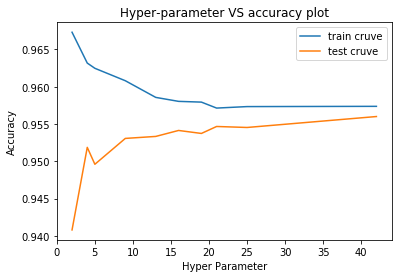

[0.9673, 0.9631666666666667, 0.9624666666666666, 0.9608000000000001, 0.9585666666666667, 0.9580333333333334, 0.9579333333333333, 0.9571333333333334, 0.9573333333333334, 0.9573666666666666] [0.9408, 0.9518666666666666, 0.9496, 0.9530666666666667, 0.9533333333333334, 0.9541333333333334, 0.9537333333333333, 0.9546666666666667, 0.9545333333333333, 0.9560000000000001]


In [21]:
plt.plot(params,trainscores, label='train cruve')
plt.plot(params,testscores, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.xlabel("Hyper Parameter")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print(trainscores,testscores)

In [22]:
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

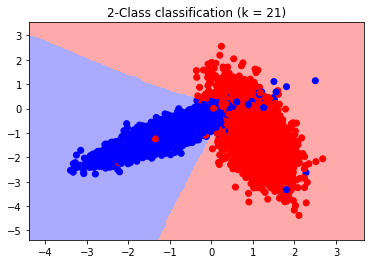

In [25]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 21)
neigh.fit(X_train, Y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], Y_train, neigh)